# Autoregressive Hidden Markov Model

This notebook illustrates how to use `jax_moseq.models.arhmm` to fit a sticky hierarchical Dirichlet process (HDP) autoregressive hidden Markov model (AR-HMM) to time series data via Gibbs sampling. The inference algorithm was originally developed by Fox et al. (2008), and applied to depth videos of mice by Wiltchsko et al. (2015). 

## Generative model

The AR-HMM models high-dimensional time-series data $\{x_1,...,x_T\}$ as a linear autogressive processes (AR) with dynamics that switch over time. In other words, it assumes that each state $x_t$ is a noisy linear function of the previous $L$ states:

\begin{align*}
x_t = A^{(z_t)} \begin{bmatrix} x_{t-L} & \cdots & x_{t-1} \end{bmatrix} + b^{(z_t)} + w_t
\end{align*}

Here the superscript $z_t$ represents a discrete state that determines the current AR dynamics and the residual $w_t$ represents Gaussian noise with covariance $Q^{(z_t)}$. Each dynamical mode $(A,b,Q)$ has a matrix normal inverse Wishart prior (MNIW):

\begin{align*}
(A,b),Q \sim \text{MNIW}(\nu_0, S_0, M_0, K_0)
\end{align*}

The discrete states $z_t$ are assumed to form a Markov chain with transition matrix $pi$

\begin{align*}
z_t \sim \text{Categorical}(\pi_{z_{t-1}})
\end{align*}

where $pi$ has sticky-HDP prior. The HDP component allows the model to adjust the number of distinct states depending on the data, and the sticky component encourages self-transitions. The sticky HDP is parameterized by

- $\gamma$ (prior on the uniformity of state frequencies)
- $\alpha$ (prior on similarity of the rows of $\pi$)
- $\kappa$ (bias toward self-transitions)


### References
[1] Fox, E., Sudderth, E., Jordan, M., & Willsky, A. (2008). Nonparametric Bayesian learning of switching linear dynamical systems. Advances in neural information processing systems, 21.

[2] Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., Abraira1, V. E., Adams, R. P., & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.

## Simulate example data

To test the model, we will simulate a 2D trajectory that alternates between two AR processes, with a $P = 0.05$ probability of switching at each time step. The processes include: 

\begin{align*}
\text{decaying toward a fixed point: } \ \  & A = \begin{bmatrix} 0.9 & 0 \\ 0 & 0.9 \end{bmatrix} \ \ \ b = \begin{bmatrix} 0.1 \\ 0.2 \end{bmatrix} \\
\text{spiralling toward the origin:} \ \ & A = \begin{bmatrix} 0.9 & -0.1 \\ 0.1 & 0.9 \end{bmatrix} \ \ \ b = \begin{bmatrix} 0 \\ 0 \end{bmatrix}
\end{align*}


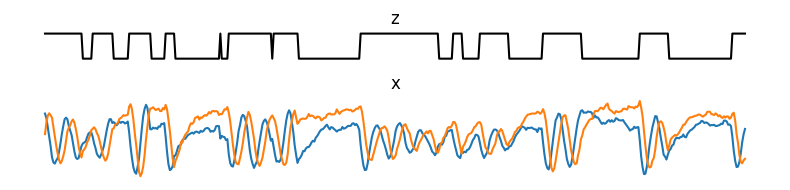

In [84]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import tqdm

# define parameters

As = np.array([
    [[ 0.9,  0   ],
     [ 0,    0.9 ]],
    [[ 0.9, -0.4 ],
     [ 0.4,  0.9]]])

bs = np.array([
     [ 0.1,  0.2  ],
     [ 0,    0    ]])

Q = np.eye(2)*0.01

pi = np.eye(2)*0.9 + 0.05


# simulate

num_steps = 10000

xs = [np.random.normal(0,1,(2,))]
zs = [np.random.randint(2)]

for step in range(num_steps):
    z = np.random.choice(2, p=pi[zs[-1]])
    w = np.random.multivariate_normal(np.zeros(2), Q)
    x = A[z] @ xs[-1] + b[z] + w
    zs.append(z)
    xs.append(x)
    
xs = np.array(xs)
zs = np.array(zs)

# plot

start,end = 0,500
fig,axs = plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios':[1,3]})
axs[0].plot(zs[start:end], c='k')
axs[0].set_title('z')
axs[1].plot(xs[start:end,0])
axs[1].plot(xs[start:end,1])
axs[1].set_title('x')
for ax in axs: ax.axis('off')
fig.set_size_inches((8,2))
plt.tight_layout()

## Fit AR-HMM

### Define data dictionary
The data is stored in a dictionary with two entries: 
- `x`: jax array of shape `(num_sequences, num_timesteps, obs_dim)` with one or more multivariate time-series
- `mask`: jax array of shape `(num_sessions, num_timesteps)` indicating which data points are valid (useful for combining time-series of different lengths)

In [4]:
data = {
    'x': jax.device_put([xs]),
    'mask': jnp.ones((x.shape[:2]))
}

x
  (25, 37800, 10)
mask
  (25, 37800)


#### Setting the Hyperparameters

In [5]:
latent_dim = obs_dim = data['x'].shape[-1]
num_states = 100          # max number of states
nlags = 3                 # number of lags for AR dynamics

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 5.7, 
    'kappa': 1e6,
    'num_states':num_states
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'nlags':  nlags,
    'latent_dim': latent_dim
}

#### Fitting the Model

In [6]:
model = arhmm.init_model(data,
                         ar_hypparams=ar_hypparams,
                         trans_hypparams=trans_hypparams,
                         verbose=True)

print_dict(model)

ARHMM: Initializing hyperparameters
ARHMM: Initializing parameters
ARHMM: Initializing states
seed
  (2,)
hypparams
  trans_hypparams
    gamma
      1000.0
    alpha
      5.7
    kappa
      1000000.0
    num_states
      100
  ar_hypparams
    S_0_scale
      0.01
    K_0_scale
      10
    num_states
      100
    nlags
      3
    latent_dim
      10
    S_0
      (10, 10)
    K_0
      (31, 31)
    M_0
      (10, 31)
    nu_0
      12
params
  betas
    (100,)
  pi
    (100, 100)
  Ab
    (100, 10, 31)
  Q
    (100, 10, 10)
states
  z
    (25, 37797)


In [7]:
num_iters = 50    # number of training iterations

ll_keys = ['z', 'x']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    model = arhmm.resample_model(data, **model)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    ll = arhmm.model_likelihood(data, **model)
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

  0%|          | 0/50 [00:00<?, ?it/s]

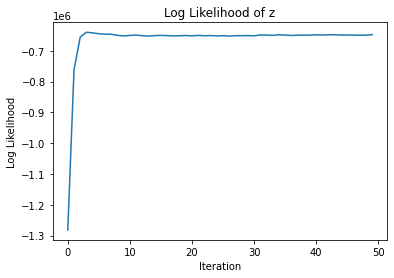

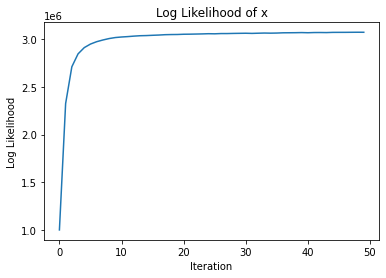

In [8]:
for k, v in ll_history.items():
    plot_ll(k, v)